# Biol 359A | Regularization
### Spring 2024, Week 6
Objectives:
- Understand the Bias-Variance Tradeoff: Learn how increasing model complexity impacts bias and variance.
- Apply Goodness-of-Fit Metrics: Use R² and Adjusted R² to evaluate model fit.
- Gain intuition for Regularization Techniques: Implement Ridge, LASSO, and Elastic Net to prevent overfitting.
- Implement Model Evaluation and Selection: Employ train-test splits and cross-validation for optimal model selection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from ipywidgets import interactive, IntSlider, FloatSlider, Dropdown, fixed, Output
import seaborn as sns
import textwrap


Today we will start by working with in-silico data. The code below will generate the data.

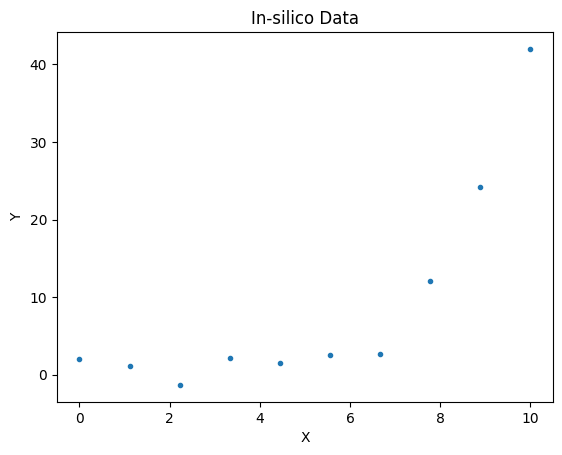

In [2]:
# Set random seed for reproducibility
np.random.seed(9)

# Generate x values drawn from normal distribution with mean 4.5 and std deviation of 5
#x = np.random.normal(4.5, 5, 70)
x = np.linspace(0, 10, 10)

# Define a 5th order polynomial function
# Coefficients for the polynomial: ax^5 + bx^4 + cx^3 + dx^2 + ex + f
a, b, c, d, e, f = 0.0005, -0.001, 0.002, -0.001, 0.005, 2

# Calculate y values based on the polynomial function
y = a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f

# Add random noise
noise = np.random.randn(10) * 3
y_noisy = y + noise

# Create a new array that combines x and y, sort by x, then separate them
combined = np.column_stack((x, y_noisy))
sorted_combined = combined[np.argsort(combined[:, 0])]
x_sorted = sorted_combined[:, 0]
y_sorted = sorted_combined[:, 1]

# Plot the sorted data
plt.scatter(x_sorted, y_sorted, marker=".")
plt.title('In-silico Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


We want to build a linear regression model that will help us learn about the system that generated these data. To make the coefficients of our model more comperable to each other, we need to start by standardizing our data.

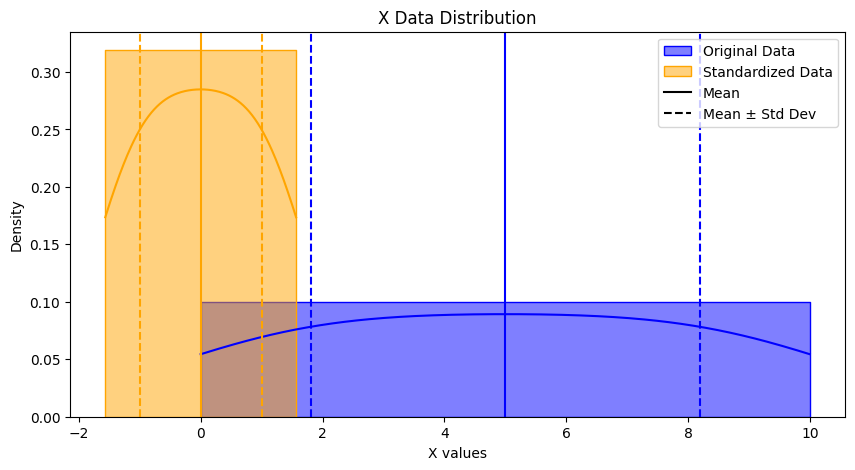

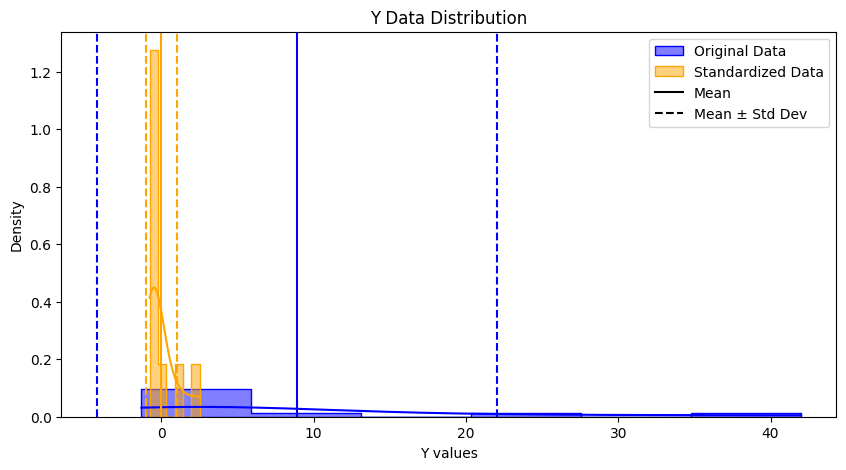

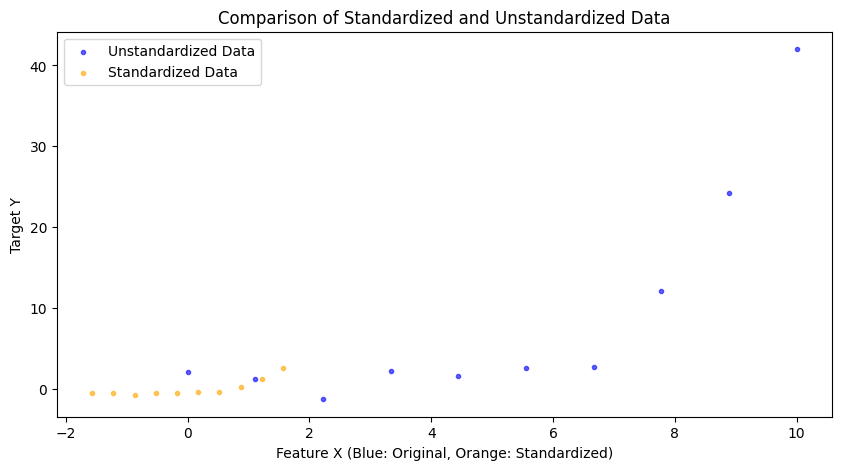

In [3]:
def plot_standardized_distributions(data, title, color):
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std = np.std(data)
    
    # Standardize the data
    data_zscore = (data - mean) / std
    
    # Calculate z-scored mean and std deviation
    zscored_mean = np.mean(data_zscore)
    zscored_std = np.std(data_zscore)
    
    # Plotting the original and standardized data
    plt.figure(figsize=(10, 5))
    sns.histplot(data, kde=True, color=color, label='Original Data', element='step', stat='density')
    sns.histplot(data_zscore, kde=True, color='orange', label='Standardized Data', element='step', stat='density')
    plt.xlabel(f'{title} values')
    plt.ylabel('Density')
    plt.axvline(mean, color=color, linestyle='-', label='Mean')
    plt.axvline(mean + std, color=color, linestyle='--', label='Mean ± Std Dev')
    plt.axvline(mean - std, color=color, linestyle='--')
    plt.axvline(zscored_mean, color='orange', linestyle='-')
    plt.axvline(zscored_mean + zscored_std, color='orange', linestyle='--')
    plt.axvline(zscored_mean - zscored_std, color='orange', linestyle='--')
    plt.title(f'{title} Data Distribution')
    legend = plt.legend()
    # Set all line colors in the legend to black
    for line in legend.get_lines():
        line.set_color('black')
    plt.show()

# Plot for x data
plot_standardized_distributions(x, 'X', 'blue')
plot_standardized_distributions(y_noisy, 'Y', 'blue')

# Standardizing the data
scaler_x = StandardScaler()
x_standardized = scaler_x.fit_transform(x_sorted[:, np.newaxis]).flatten()
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y_sorted[:, np.newaxis]).flatten()

# Plot the unstandardized and standardized data
plt.figure(figsize=(10, 5))
plt.scatter(x_sorted, y_sorted, color='blue', alpha=0.6, label='Unstandardized Data', marker=".")
plt.scatter(x_standardized, y_standardized, color='orange', alpha=0.6, label='Standardized Data', marker=".")
plt.title('Comparison of Standardized and Unstandardized Data')
plt.xlabel('Feature X (Blue: Original, Orange: Standardized)')
plt.ylabel('Target Y')
plt.legend()
plt.show()

## The Bias-Variance Tradeoff

- Bias: Bias is the error introduced by approximating a real-world problem, which might be highly complex, with a simpler model. It reflects how well the model captures the underlying patterns of the data. High bias can cause the model to miss relevant relations between features and target outputs (underfitting).

- Variance: Variance measures how much the model's predictions vary for a given dataset. A model with high variance pays a lot of attention to training data and learns noise as well as signals, leading to less generalizable models on new data (overfitting).

The interactive plot below allows you to explore this concept. The interactive slider allows you to adjust the degree of the polynomial regression model applied to synthetic data. The polynomial features (like x, x^2) and the corresponding model coefficients are displayed in the model equation and the resulting model predictions are plotted on the synthetic data. As you increase the polynomial degree, observe how the model predictions change:

- Low-degree polynomials may show high bias, where the model is too simplistic to capture the essential patterns in the data, resulting in a poor fit.
- High-degree polynomials may exhibit high variance, fitting not only the underlying data pattern but also the noise. This is seen as the model begins to closely trace minor fluctuations in the data, indicating overfitting.

As you adjust the slider, observe changes in the Mean Squared Error (MSE) and R-squared values below the plot. The MSE will help you understand the average squared difference between the observed and predicted values, while the R-squared value indicates the proportion of the variance in the dependent variable that is predictable from the independent variable.

In [4]:
def plot_polynomial_complexity_MLR(degree):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_standardized[:, np.newaxis])
    
    model = LinearRegression()
    model.fit(x_poly, y_standardized)
    y_poly_pred = model.predict(x_poly)
    
    # Generating polynomial feature names and equation
    feature_names = ['x^{}'.format(i) if i > 1 else 'x' for i in range(1, degree + 1)]
    coefficients = model.coef_
    equation_terms = [f"{coeff:.3f}*{name}" for coeff, name in zip(coefficients, feature_names)]
    equation = " + ".join(equation_terms)
    wrapped_equation = '\n               '.join(textwrap.wrap(equation, width=80))  # Wrap the equation
    
    # Print the complete equation
    print("Equation: y = " + wrapped_equation)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(x_standardized, y_standardized, s=20, label="Noisy Data Points")
    plt.plot(x_standardized, y_poly_pred, color='r', label=f"Polynomial Degree {degree} Fit")
    plt.xlabel("Feature X")
    plt.ylabel("Target Y")
    plt.title("Polynomial Regression Fit")
    plt.legend()
    plt.show()
    
    # Calculate and print errors as a measure of Bias and Variance
    mse = mean_squared_error(y_standardized, y_poly_pred)
    rsquared = model.score(x_poly, y_standardized)
    print(f"Mean Squared Error (MSE) for Degree {degree}: {mse:.2f}")
    print(f"R-Squared for Degree {degree}: {rsquared:.2f}")

# Create interactive widget
degree_slider = IntSlider(min=1, max=11, step=1, value=1, description="Polynomial Degree",
                          style={'description_width': 'initial'},
                          layout={'width': '500px'})
interactive_plot = interactive(plot_polynomial_complexity_MLR, degree=degree_slider)
interactive_plot

interactive(children=(IntSlider(value=1, description='Polynomial Degree', layout=Layout(width='500px'), max=11…

DISCUSSION QUESTION:
- Are there $\beta_0$ terms in any of the model equations? Why or why not?

#### Ridge regression

The interactive visualization below performs Ridge regression on these data. Use the sliders to adjust the polynomial degree and the lambda value, which controls the strength of the regularization:

- Polynomial Degree: Influences model complexity. Lower degrees might not capture all the data variability (underfitting), while higher degrees might model the noise as well (overfitting).
- Lambda Value: Adjusts the Ridge regularization strength. Increasing lambda enhances the model's generalization by penalizing large coefficients, helping to prevent overfitting.

Observe how adjusting the lambda values impacts the coefficients.

In [5]:
def plot_polynomial_complexity_Ridge(degree, alpha):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_standardized[:, np.newaxis])
    
    # Using Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(x_poly, y_standardized)
    y_poly_pred = model.predict(x_poly)
    
    # Generating polynomial feature names and equation
    feature_names = ['x^{}'.format(i) if i > 1 else 'x' for i in range(1, degree + 1)]
    coefficients = model.coef_
    equation_terms = [f"{coeff:.3f}*{name}" for coeff, name in zip(coefficients, feature_names)]
    equation = " + ".join(equation_terms)
    wrapped_equation = '\n               '.join(textwrap.wrap(equation, width=80))  # Wrap the equation
    
    # Print the complete equation
    print("Equation: y = " + wrapped_equation)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(x_standardized, y_standardized, s=20, label="Standardized Data Points")
    plt.plot(x_standardized, y_poly_pred, color='r', label=f"Ridge Degree {degree} Fit, Alpha {alpha}")
    plt.xlabel("Standardized Feature X")
    plt.ylabel("Standardized Target Y")
    plt.title("Ridge Polynomial Regression Fit")
    plt.legend()
    plt.show()
    
    # Calculate and print errors as a measure of Bias and Variance
    mse = mean_squared_error(y_standardized, y_poly_pred)
    rsquared = model.score(x_poly, y_standardized)
    print(f"Mean Squared Error (MSE) for Degree {degree}: {mse:.2f}")
    print(f"R-Squared for Degree {degree}: {rsquared:.2f}")

# Create interactive widgets
degree_slider = IntSlider(min=1, max=11, step=1, value=1, description="Polynomial Degree",
                          style={'description_width': 'initial'},
                          layout={'width': '500px'})
lambda_slider = FloatSlider(min=0, max=1, step=.01, value=.1, description="Lambda",
                         style={'description_width': 'initial'},
                         layout={'width': '500px'})

# Keen observers may notice that we rename lambda to alpha in the function (see below). This is because lambda is a reserved keyword in Python.
interactive_plot = interactive(plot_polynomial_complexity_Ridge, degree=degree_slider, alpha=lambda_slider)
interactive_plot


interactive(children=(IntSlider(value=1, description='Polynomial Degree', layout=Layout(width='500px'), max=11…

#### Lasso

This interactive visualization showcases Lasso regression applied to polynomial models. Adjust the polynomial degree and alpha value using the provided sliders to explore their effects:

- Polynomial Degree: Controls the complexity of the model. Lower degrees might result in underfitting, where the model is too simplistic, while higher degrees might lead to overfitting, capturing noise instead of just the underlying data pattern.
- Lambda Value: Manages the Lasso regularization strength, promoting sparsity in the model coefficients. Higher lambda values can lead to more coefficients being reduced to zero, simplifying the model and potentially improving its generalizability.

Observe how changing the lambda value affects the number of parameters in the model.

In [6]:
def plot_polynomial_complexity_Lasso(degree, alpha):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_standardized[:, np.newaxis])
    
    # Using Lasso regression model
    model = Lasso(alpha=alpha, max_iter=10000)
    model.fit(x_poly, y_standardized)
    y_poly_pred = model.predict(x_poly)
    
    # Generating polynomial feature names and equation
    feature_names = ['x^{}'.format(i) if i > 1 else 'x' for i in range(1, degree + 1)]
    coefficients = model.coef_
    equation_terms = [f"{coeff:.3f}*{name}" if coeff != 0 else "" for coeff, name in zip(coefficients, feature_names)]
    equation_terms = [term for term in equation_terms if term]  # Remove empty strings
    equation = " + ".join(equation_terms)
    wrapped_equation = '\n               '.join(textwrap.wrap(equation, width=80))  # Wrap the equation
    
    # Print the complete equation
    print("Equation: y = " + wrapped_equation)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.scatter(x_standardized, y_standardized, s=20, label="Standardized Data Points")
    plt.plot(x_standardized, y_poly_pred, color='r', label=f"Lasso Degree {degree} Fit, Alpha {alpha}")
    plt.xlabel("Standardized Feature X")
    plt.ylabel("Standardized Target Y")
    plt.title("Lasso Polynomial Regression Fit")
    plt.legend()
    plt.show()
    
    # Calculate and print errors as a measure of Bias and Variance
    mse = mean_squared_error(y_standardized, y_poly_pred)
    rsquared = model.score(x_poly, y_standardized)
    print(f"Mean Squared Error (MSE) for Degree {degree}: {mse:.2f}")
    print(f"R-Squared for Degree {degree}: {rsquared:.2f}")

# Create interactive widgets
degree_slider = IntSlider(min=1, max=11, step=1, value=1, description="Polynomial Degree",
                          style={'description_width': 'initial'},
                          layout={'width': '500px'})
lambda_slider = FloatSlider(min=0, max=1, step=.01, value=.1, description="Lambda",
                         style={'description_width': 'initial'},
                         layout={'width': '500px'})

interactive_plot = interactive(plot_polynomial_complexity_Lasso, degree=degree_slider, alpha=lambda_slider)
interactive_plot

interactive(children=(IntSlider(value=1, description='Polynomial Degree', layout=Layout(width='500px'), max=11…

Now we are not going to visualize the model fit with the data, we are just going to return a table. This interactive tool allows you to compare three different regression models: Standard Multilinear Regression (MLR), Lasso, and Ridge. Each model is evaluated using polynomial features of the data, which you can adjust using the provided sliders.

Use the sliders to:
- Adjust the Polynomial Degree: Use the degree slider to change the complexity of the polynomial features from 1 to 11. This adjustment affects how well each model can potentially fit the data.
- Set the Regularization Strength (Lambda): The lambda slider controls the alpha value for the Lasso and Ridge models. It adjusts the intensity of the penalty applied to the models' coefficients to prevent overfitting. For Standard MLR, this setting has no effect as there is no regularization.

The results table reports:
- Sum of Squared Errors (SSE): the total error of the predictions. Lower values indicate a better fit to the data.
- Penalties (L1 and L2): the sum of the absolute values of the coefficients (L1) and the sum of the squares of the coefficients (L2). These values are relevant for Lasso and Ridge, respectively, and help in assessing the impact of regularization.
- Number of Parameters: how many coefficients are actively used in the model. Lasso may set some coefficients to zero, reducing the effective number of parameters.
- Full Cost: combines the SSE with the penalties, giving a comprehensive measure of model performance considering both fit and complexity.

Review the full cost and the number of parameters to gauge each model's efficiency and complexity. Consider models with lower SSE and appropriate costs, which balance fit and simplicity, to prevent overfitting. Use the R-squared values to understand how well each model's variability explains the dependent variable.

Choose the model (type, polynomial degree, and lambda if relevant) that you believe best fits the data based on these metrics.

In [11]:
def compare_models(degree, alpha_value):
    # Prepare the polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_standardized[:, np.newaxis])

    # Initialize models with a dynamic alpha value for regularization
    models = {
        'Linear': LinearRegression(),
        'Lasso': Lasso(alpha=alpha_value, max_iter=10000),
        'Ridge': Ridge(alpha=alpha_value)
    }

    # Table to store results
    results = []

    # Fit models and calculate errors and penalties
    for name, model in models.items():
        model.fit(x_poly, y_standardized)
        y_poly_pred = model.predict(x_poly)

        # Calculating SSE
        sse = np.sum((y_standardized - y_poly_pred) ** 2)

        # Calculating L1 and L2 penalties
        L1_penalty = np.sum(np.abs(model.coef_)) if name != 'Linear' else 0
        L2_penalty = np.sum(np.square(model.coef_)) if name != 'Linear' else 0

        # Calculating full cost
        full_cost = sse + alpha_value * L1_penalty if name == 'Lasso' else sse + alpha_value * L2_penalty if name == 'Ridge' else sse

        # Number of parameters
        num_params = len([param for param in model.coef_ if param != 0])
        
        results.append({
            'Model': name,
            'SSE': sse,
            'Penalty': 'L1' if name == 'Lasso' else 'L2' if name == 'Ridge' else 'None',
            'L1': L1_penalty,
            'L2': L2_penalty,
            'Number of Parameters' : num_params,
            'Full Cost': full_cost
        })

    # Create a DataFrame to display the results
    results_df = pd.DataFrame(results)
    display(results_df.set_index('Model'))  # Use display to show the DataFrame in the interactive output

# Create interactive widgets for the degree of the polynomial and alpha value
degree_slider = IntSlider(min=1, max=11, step=1, value=3, description="Polynomial Degree",
                          style={'description_width': 'initial'},
                          layout={'width': '500px'})
lambda_slider = FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description="Lambda",
                           style={'description_width': 'initial'},
                           layout={'width': '500px'})

interactive_plot = interactive(compare_models, degree=degree_slider, alpha_value=lambda_slider)
interactive_plot

interactive(children=(IntSlider(value=3, description='Polynomial Degree', layout=Layout(width='500px'), max=11…

In [12]:
def plot_parity(model_type, degree, alpha_value):
    # Prepare the polynomial features
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly = polynomial_features.fit_transform(x_standardized[:, np.newaxis])

    # Choose the model based on user input
    if model_type == 'Standard MLR':
        model = LinearRegression()
    elif model_type == 'Lasso':
        model = Lasso(alpha=alpha_value, max_iter=10000)
    elif model_type == 'Ridge':
        model = Ridge(alpha=alpha_value)

    # Fit the model
    model.fit(x_poly, y_standardized)
    y_poly_pred = model.predict(x_poly)

    # Calculating the R^2 score
    r_squared = r2_score(y_standardized, y_poly_pred)

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(y_standardized, y_poly_pred, alpha=0.7, color='dodgerblue', label=f'Predicted vs. Actual')
    plt.plot(y_standardized, y_standardized, color='red', linestyle='--', label='Ideal Fit')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Parity Plot: {model_type} (Degree {degree}, Lambda {alpha_value})\n$R^2={r_squared:.3f}$')
    plt.legend()
    plt.grid(True)
    plt.show()

# Creating interactive widgets
model_dropdown = Dropdown(
    options=['Standard MLR', 'Lasso', 'Ridge'],
    value='Standard MLR',
    description='Model Type:',
    disabled=False,
)

degree_slider = IntSlider(
    min=1, 
    max=12, 
    step=1, 
    value=3, 
    description="Degree",
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

lambda_slider = FloatSlider(
    min=0.0, 
    max=1.0, 
    step=0.01, 
    value=0.1, 
    description="Lambda",
    style={'description_width': 'initial'},
    layout={'width': '400px'}
)

# Create interactive output
interactive_output = interactive(plot_parity, model_type=model_dropdown, degree=degree_slider, alpha_value=lambda_slider)

# Display the interactive output and sliders
display(interactive_output)

interactive(children=(Dropdown(description='Model Type:', options=('Standard MLR', 'Lasso', 'Ridge'), value='S…

Discussion question:
- What degree did you choose? Why?

Great, Now we are going to pretend we gathered a lot more data of the same system. Set the variables in the first three lines to make the function plot the model you selected in the exercise above. How good is the fit? What changes can you make to the model to improve the predictions?

In [14]:
# SET HYPERPARAMETERS HERE:
initial_model_type = 'Standard MLR'
initial_degree = 1
initial_lambda = 0.1
# ------------------------------------

# Generate more data
x_new = np.linspace(0, 10, 100)  # More data points for better visualization
y_new = 0.0005*x_new**5 - 0.001*x_new**4 + 0.002*x_new**3 - 0.001*x_new**2 + 0.005*x_new + 2
noise_new = np.random.randn(100) * 3  # Same noise level
y_noisy_new = y_new + noise_new

# Standardize the new data
scaler_x = StandardScaler()
x_standardized_new = scaler_x.fit_transform(x_new[:, np.newaxis]).flatten()
scaler_y = StandardScaler()
y_standardized_new = scaler_y.fit_transform(y_noisy_new[:, np.newaxis]).flatten()

def plot_model_predictions(model_type, degree, alpha):
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=False)
    x_poly_new = polynomial_features.fit_transform(x_standardized_new[:, np.newaxis])
    
    if model_type == 'Standard MLR':
        model = LinearRegression()
    elif model_type == 'Lasso':
        model = Lasso(alpha=alpha, max_iter=10000)
    elif model_type == 'Ridge':
        model = Ridge(alpha=alpha)
        
    model.fit(x_poly_new, y_standardized_new)
    y_poly_pred_new = model.predict(x_poly_new)

    plt.figure(figsize=(10, 6))
    plt.scatter(x_standardized_new, y_standardized_new, color='blue', label='Actual Data')
    plt.plot(x_standardized_new, y_poly_pred_new, color='red', label='Model Prediction')
    plt.title(f'Model Type: {model_type}, Degree: {degree}, Lambda: {alpha}\nR^2: {r2_score(y_standardized_new, y_poly_pred_new):.3f}')
    plt.xlabel('Standardized X')
    plt.ylabel('Standardized Y')
    plt.legend()
    plt.show()

# Interactive widgets setup
model_dropdown = Dropdown(options=['Standard MLR', 'Lasso', 'Ridge'], value=initial_model_type, description='Model Type:')
degree_slider = IntSlider(min=1, max=11, value=initial_degree, description='Polynomial Degree', continuous_update=False)
lambda_slider = FloatSlider(min=0.0, max=1.0, value=initial_lambda, step=0.01, description='Lambda', continuous_update=False)

interactive_plot = interactive(plot_model_predictions, model_type=model_dropdown, degree=degree_slider, alpha=lambda_slider)
display(interactive_plot)


interactive(children=(Dropdown(description='Model Type:', options=('Standard MLR', 'Lasso', 'Ridge'), value='S…

Most of the time, we can't collect a bunch of new data to see how well our model generalizes. Instead, we have to split our existing data into "training data", which we use to build our model and select which model we think best describes our data, and "testing data" which we use to assess our model's generalizability. The code below splits the data from above into a training data set (which is a randomly selected 70% of the data) and a testing set (the remaining 30%)

In [ ]:
# Separates data into training and test sets
def train_test_split(x, y, test_size=0.2):
    # Shuffle the data
    indices = np.random.permutation(len(x))
    x_shuffled = x[indices]
    y_shuffled = y[indices]
    
    # Split the data into training and test sets
    split_index = int(len(x) * (1 - test_size))
    x_train, x_test = x_shuffled[:split_index], x_shuffled[split_index:]
    y_train, y_test = y_shuffled[:split_index], y_shuffled[split_index:]
    
    return x_train, x_test, y_train, y_test

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x_standardized, y_standardized)